<a href="https://colab.research.google.com/github/lorenzrossi/AMD-ComicsFaces/blob/main/AMD_Models_batch_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from os import listdir
import pandas as pd
# Basic packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

# Image preprocessing
import pathlib
import PIL
import PIL.Image
import cv2

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical, load_img, img_to_array
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, callbacks, regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.losses import binary_crossentropy
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Cross Validation
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, zero_one_loss

tfk = tf.keras
tf.keras.backend.set_floatx("float64")


from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/ComicsFaces'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
X = pickle.load(open('/content/drive/MyDrive/ComicsFaces/Pickles/X.pickle','rb'))
y = pickle.load(open('/content/drive/MyDrive/ComicsFaces/Pickles/y.pickle','rb'))

pics_classes = ['comics','faces']

images_to_plot = 8

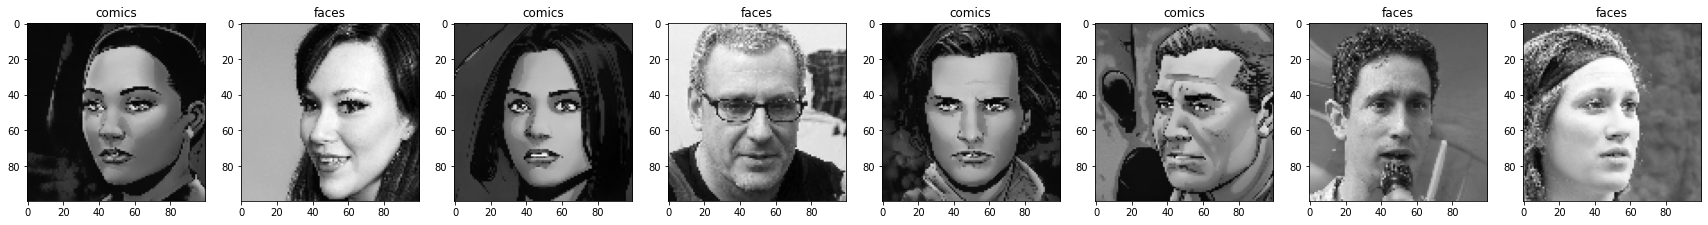

In [3]:
f, ax = plt.subplots(1, images_to_plot)
f.set_size_inches(30, 20)

gray_channel = 0

for i in range(images_to_plot):
  gray_image = X[i][:, :, gray_channel]
  ax[i].imshow(gray_image, cmap = "gray")
  numeric_label = y[i]
  ax[i].set_title(pics_classes[numeric_label])

In [4]:
number_of_classes = len(pics_classes)

In [5]:
x_size, img_dim = X.shape[0], X.shape[1]

# rescale in [0,1]
X = tf.cast(X, tf.float32) / 255.0

# one hot encoding
depth = 1
y = tf.reshape(tf.one_hot(y, depth), shape = [x_size, depth])

In [6]:
# Train test splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [7]:
# Hyperparameters
epoch = 40 # n of epochs
batch = 128 # batch size

# Defining the loss
loss = keras.losses.BinaryCrossentropy(from_logits = True)

# Defining the optimizer(s)
op_1 = Adam()
op_2 = SGD(learning_rate=0.01, momentum=0.9, decay=0.01/50)
op_3 = RMSprop(learning_rate=1e-3)

In [8]:
# Defining plots
legend_size = 14

def performance_plot(history):
    plt.figure(figsize=(20,8))

    # Loss plots
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','test'], fontsize = legend_size)

    # Accuracy plots
    plt.subplot(1,2,2)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.ylabel('accuracy', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)

    plt.show()

# TRAINING MODEL 1

In [9]:
model1 = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation = 'sigmoid')
        ])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      288       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                        

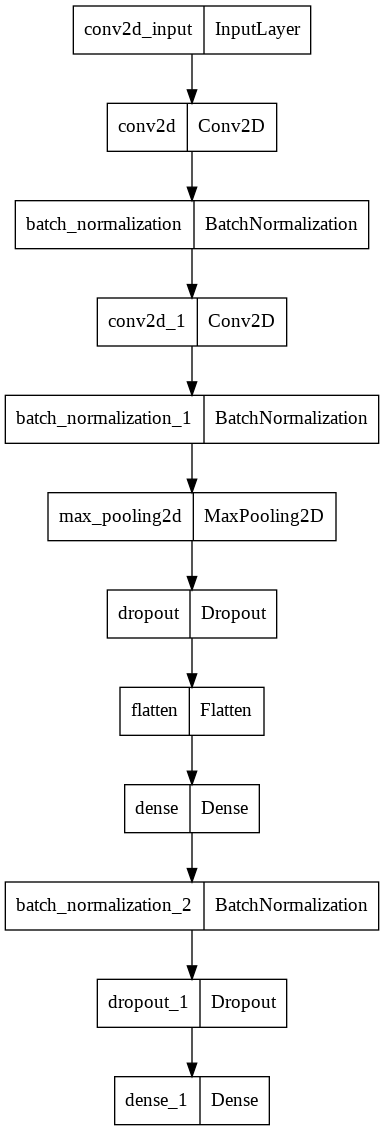

In [10]:
keras.utils.plot_model(model1, 'model.png')

Epoch 1/40


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


100/100 [==============================] - 11s 64ms/step - loss: 0.0354 - binary_accuracy: 0.9885 - val_loss: 2.0365 - val_binary_accuracy: 0.5012
Epoch 2/40
100/100 [==============================] - 6s 61ms/step - loss: 0.0030 - binary_accuracy: 0.9994 - val_loss: 4.0140 - val_binary_accuracy: 0.5069
Epoch 3/40
100/100 [==============================] - 6s 62ms/step - loss: 0.0013 - binary_accuracy: 0.9998 - val_loss: 5.3094 - val_binary_accuracy: 0.5069
Epoch 4/40
100/100 [==============================] - 6s 62ms/step - loss: 7.1625e-04 - binary_accuracy: 0.9998 - val_loss: 2.5970 - val_binary_accuracy: 0.6053
Epoch 5/40
100/100 [==============================] - 6s 61ms/step - loss: 5.4592e-04 - binary_accuracy: 0.9999 - val_loss: 0.2259 - val_binary_accuracy: 0.9572
Epoch 6/40
100/100 [==============================] - 6s 61ms/step - loss: 8.8552e-04 - binary_accuracy: 0.9998 - val_loss: 0.0109 - val_binary_accuracy: 0.9972
Epoch 7/40
100/100 [==============================] - 6s

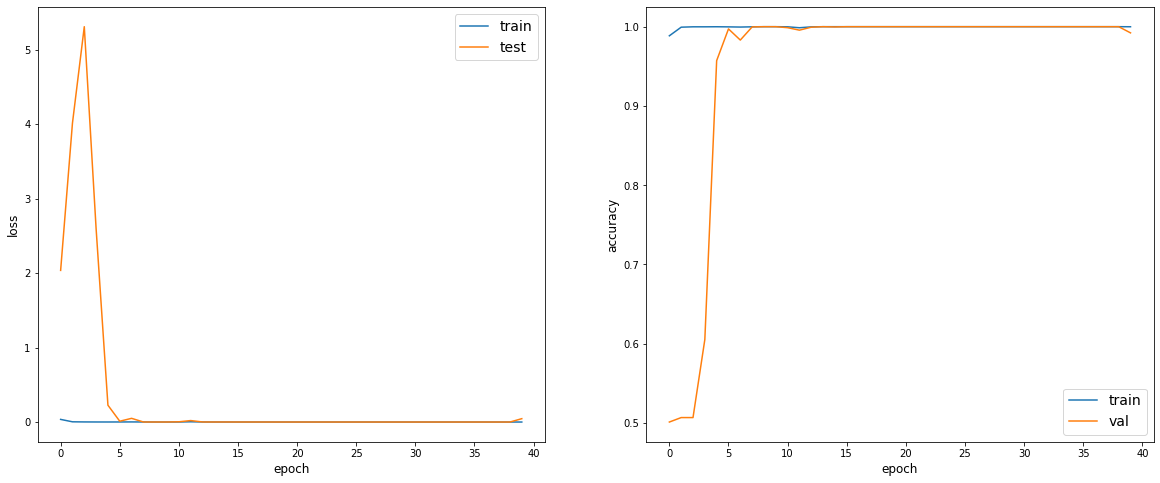

125/125 [==============================] - 1s 7ms/step - loss: 0.0184 - binary_accuracy: 0.9955
test loss, test acc: [0.018409381009355307, 0.9955]


In [11]:
# compiling the model
model1.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model1.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_1 = model1.evaluate(X_test, y_test)
print("test loss, test acc:", result_1)

# TRAINING MODEL 2

In [12]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_3 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_4 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                      

Epoch 1/40
100/100 [==============================] - 9s 78ms/step - loss: 0.0600 - binary_accuracy: 0.9820 - val_loss: 1.1316 - val_binary_accuracy: 0.5003
Epoch 2/40
100/100 [==============================] - 8s 75ms/step - loss: 0.0048 - binary_accuracy: 0.9994 - val_loss: 0.1992 - val_binary_accuracy: 0.9791
Epoch 3/40
100/100 [==============================] - 7s 75ms/step - loss: 0.0031 - binary_accuracy: 0.9994 - val_loss: 0.2994 - val_binary_accuracy: 0.8350
Epoch 4/40
100/100 [==============================] - 8s 75ms/step - loss: 0.0020 - binary_accuracy: 0.9995 - val_loss: 0.0354 - val_binary_accuracy: 0.9906
Epoch 5/40
100/100 [==============================] - 8s 75ms/step - loss: 8.5528e-04 - binary_accuracy: 0.9998 - val_loss: 0.0925 - val_binary_accuracy: 0.9681
Epoch 6/40
100/100 [==============================] - 7s 75ms/step - loss: 0.0011 - binary_accuracy: 0.9998 - val_loss: 0.0402 - val_binary_accuracy: 0.9894
Epoch 7/40
100/100 [==============================] - 

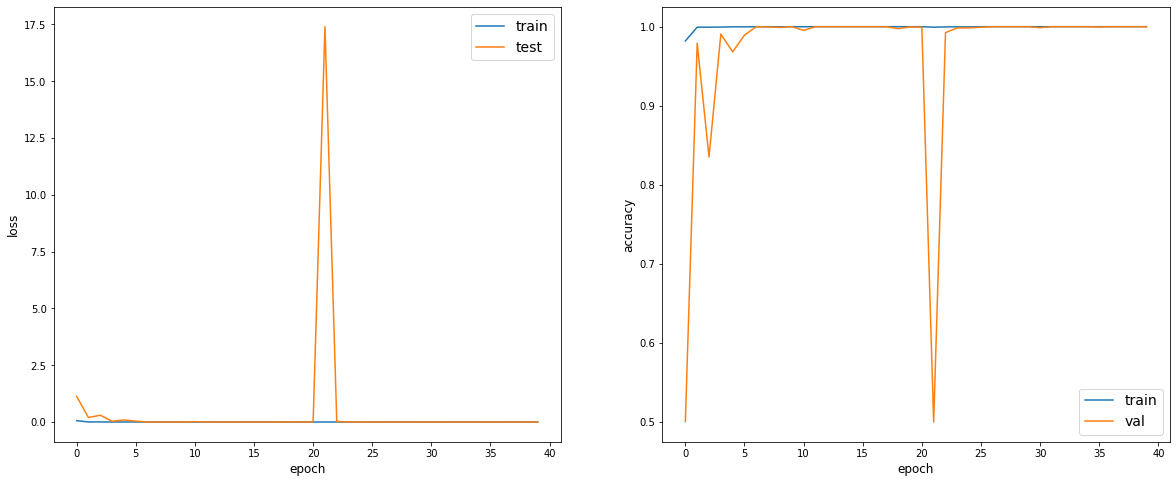

125/125 [==============================] - 1s 8ms/step - loss: 4.8864e-05 - binary_accuracy: 1.0000
test loss, test acc: [4.886418974747232e-05, 1.0]


In [14]:
# compiling the model
model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_2 = model2.evaluate(X_test, y_test)
print("test loss, test acc:", result_2)

# TRAINING MODEL 3

In [15]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_7 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_8 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                      

Epoch 1/40
100/100 [==============================] - 10s 87ms/step - loss: 0.0246 - binary_accuracy: 0.9906 - val_loss: 3.7433 - val_binary_accuracy: 0.5003
Epoch 2/40
100/100 [==============================] - 8s 84ms/step - loss: 0.0030 - binary_accuracy: 0.9993 - val_loss: 0.2972 - val_binary_accuracy: 0.8622
Epoch 3/40
100/100 [==============================] - 8s 84ms/step - loss: 0.0026 - binary_accuracy: 0.9994 - val_loss: 2.2245 - val_binary_accuracy: 0.5216
Epoch 4/40
100/100 [==============================] - 8s 84ms/step - loss: 0.0015 - binary_accuracy: 0.9996 - val_loss: 0.2650 - val_binary_accuracy: 0.8769
Epoch 5/40
100/100 [==============================] - 8s 84ms/step - loss: 9.1031e-04 - binary_accuracy: 0.9998 - val_loss: 0.1483 - val_binary_accuracy: 0.9344
Epoch 6/40
100/100 [==============================] - 8s 84ms/step - loss: 5.6238e-04 - binary_accuracy: 0.9998 - val_loss: 0.0603 - val_binary_accuracy: 0.9962
Epoch 7/40
100/100 [=============================

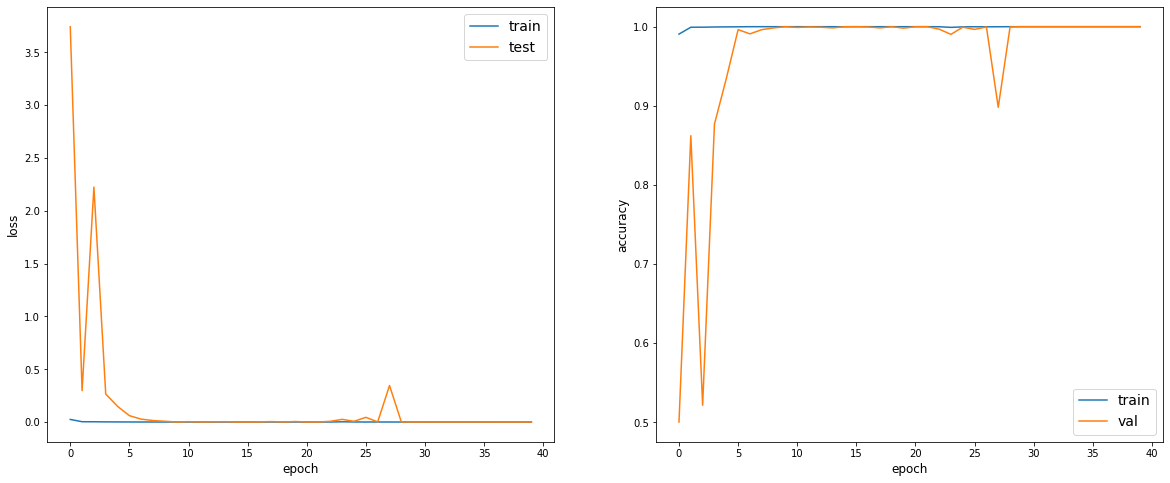

125/125 [==============================] - 1s 8ms/step - loss: 3.4646e-05 - binary_accuracy: 1.0000
test loss, test acc: [3.4646284800893006e-05, 1.0]


In [17]:
# compiling the model
model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_3 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_3)

# TRAINING MODEL 4

In [18]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_12 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_13 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                      

Epoch 1/40
100/100 [==============================] - 11s 94ms/step - loss: 0.0223 - binary_accuracy: 0.9920 - val_loss: 3.1799 - val_binary_accuracy: 0.5003
Epoch 2/40
100/100 [==============================] - 9s 91ms/step - loss: 0.0036 - binary_accuracy: 0.9990 - val_loss: 7.9069 - val_binary_accuracy: 0.5003
Epoch 3/40
100/100 [==============================] - 9s 91ms/step - loss: 0.0020 - binary_accuracy: 0.9993 - val_loss: 1.8204 - val_binary_accuracy: 0.5003
Epoch 4/40
100/100 [==============================] - 9s 91ms/step - loss: 4.7358e-04 - binary_accuracy: 1.0000 - val_loss: 2.7807 - val_binary_accuracy: 0.5003
Epoch 5/40
100/100 [==============================] - 9s 91ms/step - loss: 4.6311e-04 - binary_accuracy: 0.9998 - val_loss: 2.8318 - val_binary_accuracy: 0.5034
Epoch 6/40
100/100 [==============================] - 9s 91ms/step - loss: 2.8175e-04 - binary_accuracy: 1.0000 - val_loss: 0.1077 - val_binary_accuracy: 0.9572
Epoch 7/40
100/100 [=========================

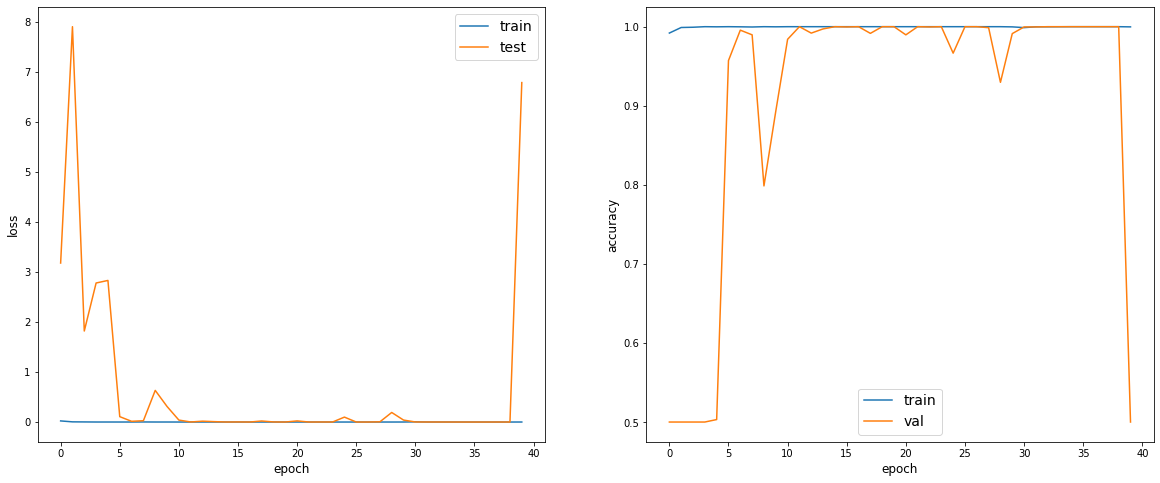

125/125 [==============================] - 1s 9ms/step - loss: 6.7995 - binary_accuracy: 0.4993
test loss, test acc: [6.799526778854863, 0.49925]


In [20]:
# compiling the model
model4.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model4.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_4 = model4.evaluate(X_test, y_test)
print("test loss, test acc:", result_4)

# TRAINING MODEL 5

In [21]:
model5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_18 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_19 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                      

Epoch 1/40
100/100 [==============================] - 12s 98ms/step - loss: 0.0313 - binary_accuracy: 0.9880 - val_loss: 5.7652 - val_binary_accuracy: 0.5003
Epoch 2/40
100/100 [==============================] - 9s 93ms/step - loss: 0.0037 - binary_accuracy: 0.9990 - val_loss: 5.2824 - val_binary_accuracy: 0.5003
Epoch 3/40
100/100 [==============================] - 9s 93ms/step - loss: 0.0037 - binary_accuracy: 0.9988 - val_loss: 5.8151 - val_binary_accuracy: 0.5003
Epoch 4/40
100/100 [==============================] - 9s 93ms/step - loss: 0.0026 - binary_accuracy: 0.9991 - val_loss: 4.9050 - val_binary_accuracy: 0.5003
Epoch 5/40
100/100 [==============================] - 9s 93ms/step - loss: 5.5314e-04 - binary_accuracy: 1.0000 - val_loss: 4.8579 - val_binary_accuracy: 0.5003
Epoch 6/40
100/100 [==============================] - 9s 93ms/step - loss: 0.0014 - binary_accuracy: 0.9995 - val_loss: 0.6799 - val_binary_accuracy: 0.7631
Epoch 7/40
100/100 [==============================] -

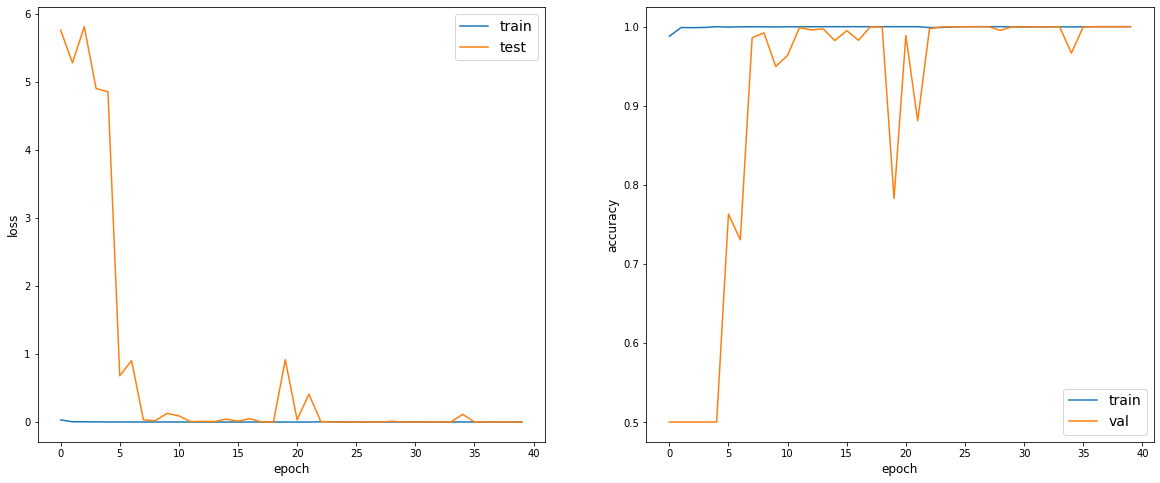

125/125 [==============================] - 1s 9ms/step - loss: 0.0015 - binary_accuracy: 0.9995
test loss, test acc: [0.0014705974469004647, 0.9995]


In [23]:
# compiling the model
model5.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model5.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_5 = model5.evaluate(X_test, y_test)
print("test loss, test acc:", result_5)

# TRAINING MODEL 6

In [24]:
model6 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(512, use_bias=False, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.25),
    #tf.keras.layers.Dense(256, use_bias=False, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_25 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_26 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                      

Epoch 1/40
100/100 [==============================] - 12s 97ms/step - loss: 0.0472 - binary_accuracy: 0.9823 - val_loss: 5.8215 - val_binary_accuracy: 0.5003
Epoch 2/40
100/100 [==============================] - 9s 94ms/step - loss: 0.0053 - binary_accuracy: 0.9980 - val_loss: 4.8223 - val_binary_accuracy: 0.5003
Epoch 3/40
100/100 [==============================] - 9s 94ms/step - loss: 0.0036 - binary_accuracy: 0.9990 - val_loss: 5.1746 - val_binary_accuracy: 0.5003
Epoch 4/40
100/100 [==============================] - 9s 94ms/step - loss: 0.0030 - binary_accuracy: 0.9987 - val_loss: 5.3846 - val_binary_accuracy: 0.5003
Epoch 5/40
100/100 [==============================] - 9s 94ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - val_loss: 3.3920 - val_binary_accuracy: 0.5156
Epoch 6/40
100/100 [==============================] - 9s 94ms/step - loss: 0.0024 - binary_accuracy: 0.9993 - val_loss: 1.0602 - val_binary_accuracy: 0.7381
Epoch 7/40
100/100 [==============================] - 9s 

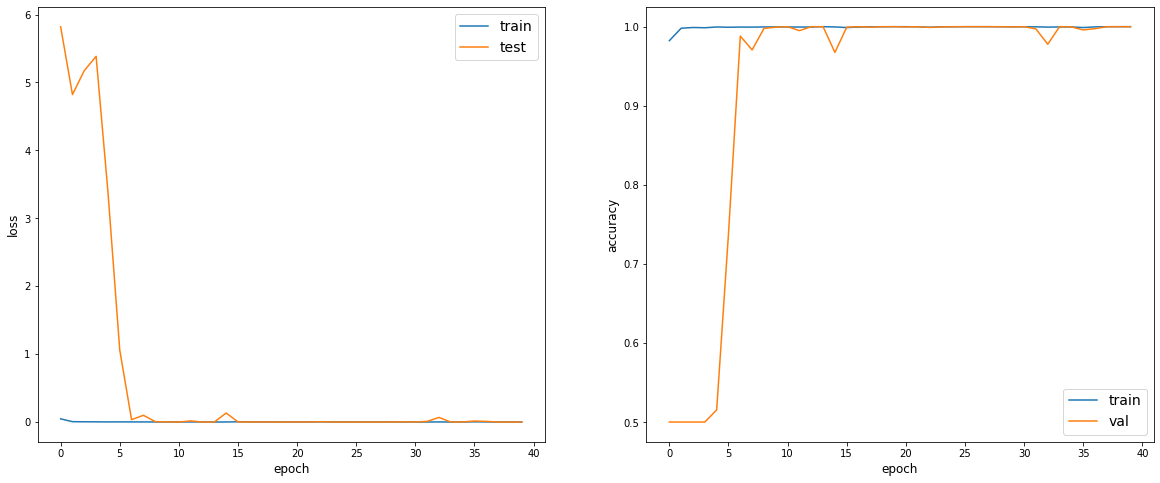

125/125 [==============================] - 1s 9ms/step - loss: 4.4296e-06 - binary_accuracy: 1.0000
test loss, test acc: [4.429561366408629e-06, 1.0]


In [26]:
# compiling the model
model6.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model6.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_6 = model6.evaluate(X_test, y_test)
print("test loss, test acc:", result_6)